In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy import optimize

# 1

In [2]:
beta = lambda x, y: np.dot(np.dot(np.linalg.inv(x.T.dot(x)), x.T), y)
predict = lambda x, b: x.dot(b)

In [3]:
noisysine = pd.read_csv('../data/noisysine.csv')
hydrodynamics = pd.read_csv('../data/hydrodynamics.csv')

In [4]:
def plot_regression(x, y, b):
    plt.figure(figsize=(10, 5))
#     plt.scatter(data, y)
    plt.scatter(x[:, 1], y)
    x_axis = np.linspace(x[:, 1].min(), x[:, 1].max(), len(x))
    y = 0
    for i in range(x.shape[1]):
        y += b[i] * x[:, i]
    plt.plot(x_axis, y, color='red') 
    plt.show()

In [5]:
def regression(data, y, power, label='y', plot=False, b_ridge=False, verbose=False, lasso=False):
    for p in range(1, power + 1):
        pf = PolynomialFeatures(p)
        x = pf.fit_transform(data)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        if b_ridge:
            r, b = ridge(x_train, y_train, verbose=verbose)
        elif lasso:
            lcv = LassoCV(cv=5, random_state=0).fit(x, y)
            b = lcv.coef_
        else:
            b = beta(x_train, y_train)
        y_pred = predict(x_test, b)
        print(f'R^2 для степени {p}')
        print(f'\tвалидация: {r2_score(y_test, y_pred):.3f}')
        y_pred = predict(x_train, b)
        print(f'\tобучающий набор: {r2_score(y_train, y_pred):.3f}')
        if plot:
            plot_regression(x_test, y_test, b)

R^2 для степени 1
	валидация: -0.338
	обучающий набор: 0.237


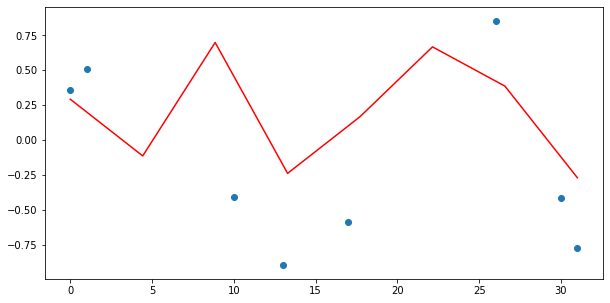

R^2 для степени 2
	валидация: -0.081
	обучающий набор: 0.204


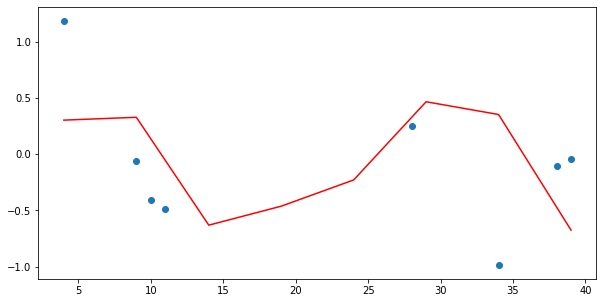

R^2 для степени 3
	валидация: 0.080
	обучающий набор: 0.320


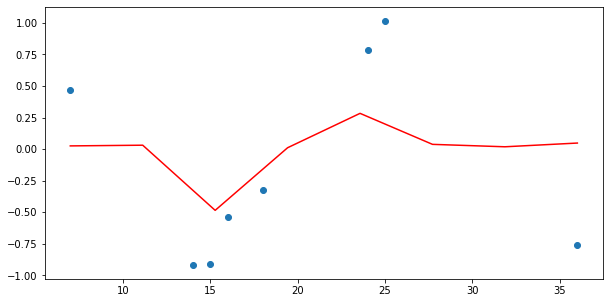

R^2 для степени 4
	валидация: 0.101
	обучающий набор: 0.316


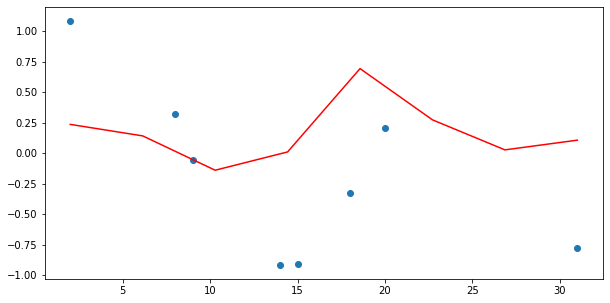

R^2 для степени 5
	валидация: 0.766
	обучающий набор: 0.900


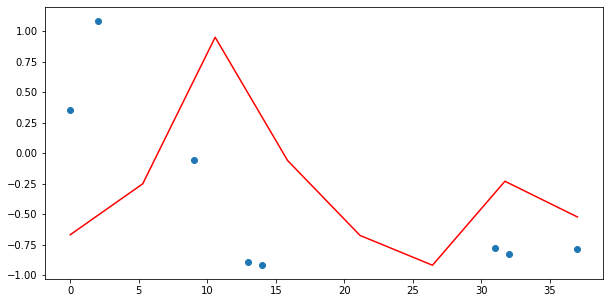

In [6]:
regression(noisysine.drop('y', axis=1), noisysine.y, 5, plot=True)

In [7]:
regression(hydrodynamics.drop('y', axis=1), hydrodynamics.y, 2)

R^2 для степени 1
	валидация: 0.633
	обучающий набор: 0.660
R^2 для степени 2
	валидация: 0.920
	обучающий набор: 0.930


# 2

In [8]:
def delta(r, b, x, t, s):
    xTxprt = x.T.dot(x) + r * t
    sqared = np.linalg.inv(xTxprt)
    inv_sqared = sqared.dot(sqared)
    return (r ** 2 * b.T).dot(inv_sqared).dot(b) + s * np.trace(x.dot(inv_sqared).dot(x.T))

def ridge(x, y, eps=0.00001, n_iter=1000, verbose=False):
    n = len(x)
    m = x.shape[1]
    t = np.eye(m, m)
    beta = lambda x, y, t: np.linalg.inv(x.T.dot(x) + r * t).dot(x.T).dot(y)

    errors = lambda x, y, b: y - x.dot(b)

    s2 = lambda errors, n, m: errors.T.dot(errors) / (n - m)

    r = 0
    i = 0
    while True:
        b = beta(x, y, t)
        
        e = errors(x, y, b)
        s = s2(e, n, m)
        r_old = r
        r = optimize.minimize(delta, [0.], args=(b, x, t, s)).x
        if verbose:
            print(f'Candidate r = {r}')
        i += 1
        if np.abs(r - r_old) <= eps or i == n_iter:
            break
    return r, b

R^2 для степени 1
	валидация: 0.105
	обучающий набор: 0.200


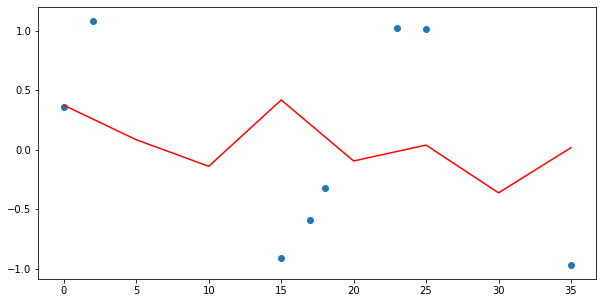

R^2 для степени 2
	валидация: -0.357
	обучающий набор: 0.124


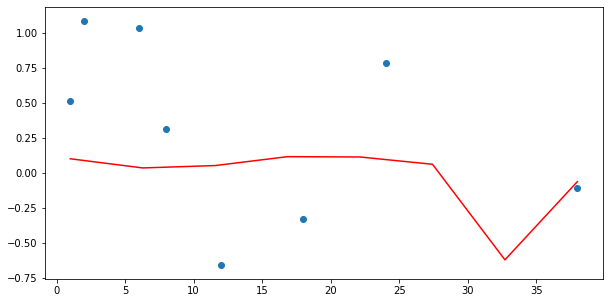

R^2 для степени 3
	валидация: 0.068
	обучающий набор: 0.331


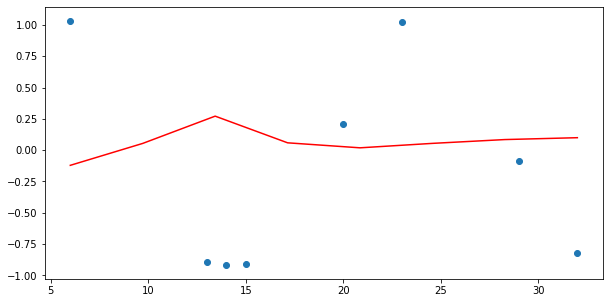

R^2 для степени 4
	валидация: 0.202
	обучающий набор: 0.311


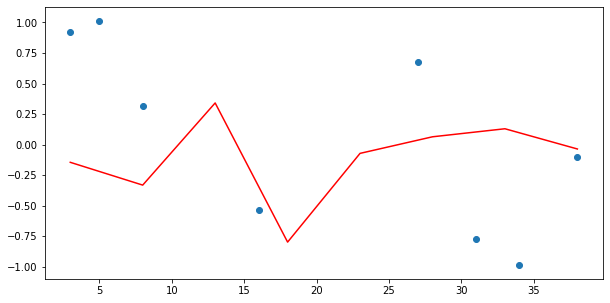

R^2 для степени 5
	валидация: 0.838
	обучающий набор: 0.901


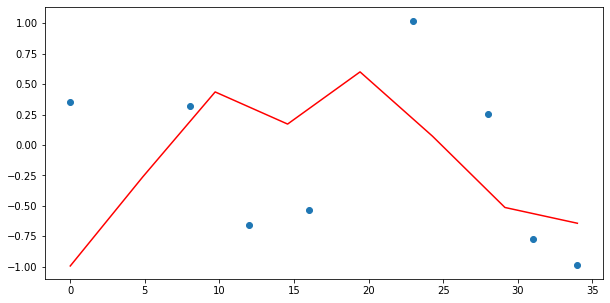

In [9]:
regression(noisysine.drop('y', axis=1), noisysine.y, 5, plot=True, b_ridge=True)

In [10]:
regression(hydrodynamics.drop('y', axis=1), hydrodynamics.y, 2, b_ridge=True)

R^2 для степени 1
	валидация: 0.580
	обучающий набор: 0.666
R^2 для степени 2
	валидация: 0.923
	обучающий набор: 0.931


# 3

R^2 для степени 1
	валидация: -0.193
	обучающий набор: -0.004


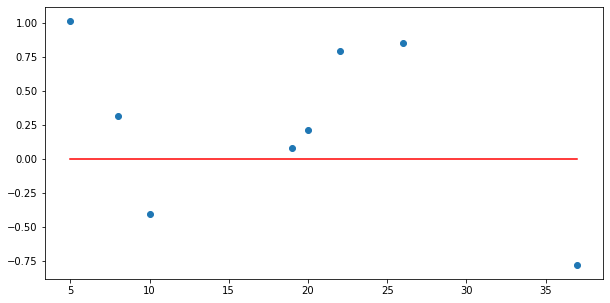

R^2 для степени 2
	валидация: -0.000
	обучающий набор: -0.001


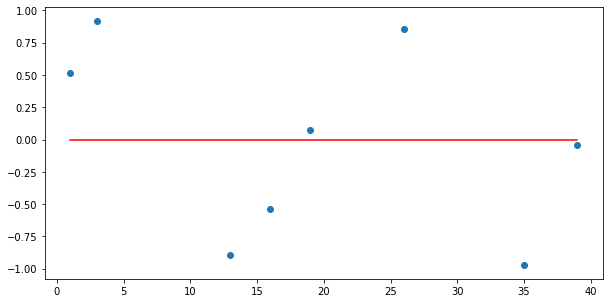

R^2 для степени 3
	валидация: -0.024
	обучающий набор: -0.005


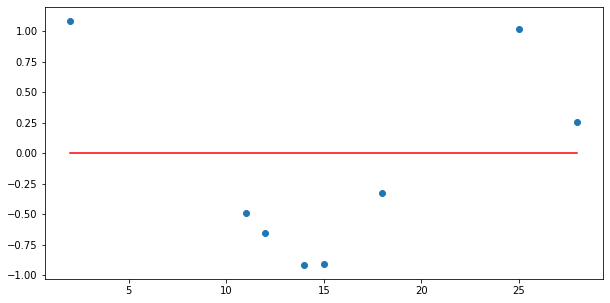

R^2 для степени 4
	валидация: -0.047
	обучающий набор: 0.085


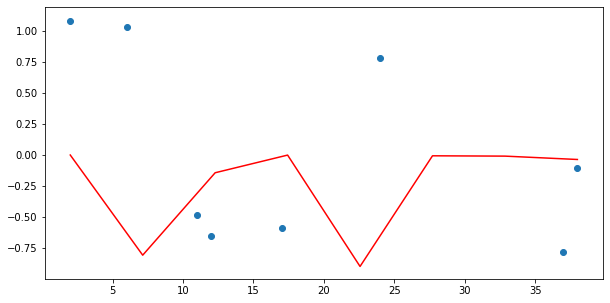

R^2 для степени 5
	валидация: -0.103
	обучающий набор: 0.105


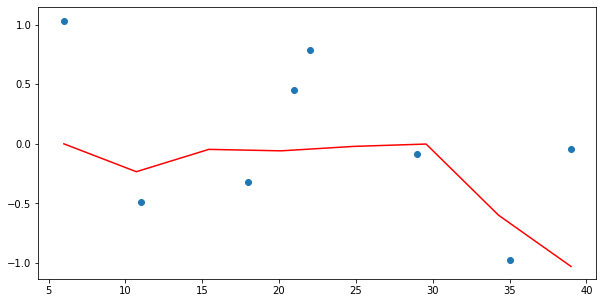

In [11]:
regression(noisysine.drop('y', axis=1), noisysine.y, 5, plot=True, lasso=True)

In [12]:
regression(hydrodynamics.drop('y', axis=1), hydrodynamics.y, 2, lasso=True)

R^2 для степени 1
	валидация: -0.666
	обучающий набор: -1.491


C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.37724803360106, tolerance: 5.81314421398374
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136.37891955450687, tolerance: 5.81314421398374
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.440964373041425, tolerance: 5.81314421398374
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.76347857442306, tolerance: 5.486792945731707
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489.53992349084274, tolerance: 5.486792945731707
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.43023273746257, tolerance: 5.486792945731707
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

R^2 для степени 2
	валидация: 0.906
	обучающий набор: 0.915


C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.38958909263056, tolerance: 5.504162042105263
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.90529111049909, tolerance: 5.504162042105263
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.805406481707905, tolerance: 5.504162042105263
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w